## Data prep and validation pipeline

In [1]:
import os
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Helper functions

In [2]:
def prepareDataset(df, dfname, dropna = True):
  ''' First pass at clean-up of data:
  add a station name to file, drop unnecesasary columns, drop duplicate rows and 
  drop any rows were the temperature variable is empty.
  Add datetime columns as index and order chronologically
  '''
  # Add station name
  #df['station'] = dfname

  # drop unnamed column + file name (to get rid of the double files with 'subir')
  if 'Unnamed: 0' in df: df.drop(columns=['Unnamed: 0'],inplace=True)
  if 'file_name' in df: df.drop(columns=['file_name'],inplace=True)
  
  #drop duplicates
  start_len= len(df)
  df.drop_duplicates(keep = 'first',inplace=True)

  # drop NAs
  if dropna: 
    #print(f'{df["ATAvg"].isna().sum()} empty ATAvg values removed = {round(df["ATAvg"].isna().sum()/len(df),2)*100}% of df')
    df.dropna(subset=['ATAvg'],inplace=True) 
    end_len=len(df)
  
  ## Keep only selected columns = 
  df = df[['Date_Time','Freq','ATAvg','ATMax','ATMin','RHAvg','RHMin','RHMax','PAvg','WSAvg','WSMin','WSMax','WDAvg','WDMin','WDMax']]
  
  ## set date time as index
  if 'Date_Time' in df:
    df.set_index('Date_Time', inplace =True)
  df.index =pd.to_datetime(df.index)
  df.sort_index(axis=0,inplace= True)


  return df

In [3]:
### Get basic information from each file
def basic_info(df):
  ''' get file infromation: frequency of sampling, number of data by sampling, 
  completness of data (gaps)
  '''
  results = pd.DataFrame(columns=['Freq','start','end','rows','gaps','gap_length'])
  results.Freq = ['1min','5min','1hora']

  replace_values ={
    '30SEG' :'30seg',
    '1MIN' : '1min',
    '5MIN' : '5min',
    '1HORA' : '1hora'}

  if df.Freq.isna().sum() == len(df):
    df =df[~df.index.duplicated(keep='first')]
    minim = df.index.min().date()
    maxim = df.index.max().date()
    print(f'avergae time between samples ={df.index.to_series().diff().mean().days}')
    print(f'start_date = {minim}, end_date = {maxim}')
    print(f'data length {len(df)}')
    print(f'expected 1 day = {(maxim - minim).days}')

  else:
    df = df.replace({'Freq':replace_values}) 
    for i in df.Freq.unique():

      dff = df[df['Freq']==i]
      dff =dff[~dff.index.duplicated(keep='first')]
      minim = dff[dff['Freq']==i].index.min().date()
      maxim = dff[dff['Freq']==i].index.max().date()
      deltas = dff.index.to_series().diff()[1:] ## drop first

      results.loc[results['Freq']==i,'start']= minim
      results.loc[results['Freq']==i,'end']= maxim
      results.loc[results['Freq']==i,'rows']= len(dff[dff["Freq"]==i])

      if i == '1min':
        gaps = deltas[deltas > pd.Timedelta(1, unit="min")]
        results.loc[results['Freq']=='1min','gaps']= len(gaps)
        results.loc[results['Freq']=='1min','gap_length']= gaps.mean()
      
      if i == '5min':
        gaps = deltas[deltas > pd.Timedelta(5, unit="min")]
        results.loc[results['Freq']=='5min','gaps']= len(gaps)
        results.loc[results['Freq']=='5min','gap_length']= gaps.mean()

      if i == '1hora':
        gaps = deltas[deltas > pd.Timedelta(1, unit="hour")]
        results.loc[results['Freq']=='1hora','gaps']= len(gaps)
        results.loc[results['Freq']=='1hora','gap_length']= gaps.mean()

  return results

In [4]:
def fill_the_gaps(df):
  ''' Split df into samples with 5 min  freq and samples with 1 min freq.
  Remove duplicate indexes from both datasets and keep first.
  Take the values from df1 (1 min) that are not in df5 and complete df5.
  df1 values are resampled to 5 min.
  '''
  # Splir datasets
  df5 = df[df['Freq']=='5min']
  df1 = df[df['Freq']=='1min']

  ### Drop duplicate indexes (the values differ, making a mean could be a better solution)
  df5 =df5[~df5.index.duplicated(keep='first')]
  df1 = df1[~df1.index.duplicated(keep='first')]
  
  ### Create an array of indexes at 5 min intervals
  #df5 = df5.asfreq(freq='5T') 
  #df1 = df1.asfreq(freq='5T')

  ### Resample df1 at 5 min intervals and drop empty rows
  df1 = df1.resample("5T").mean()
  df1.dropna(axis=0,how='all', inplace = True)
  
  # get list of indexes to fill
  fill_from_df1 = list(set(df1.index.to_list()) - set(df5.index.to_list()))

  # Append values directly
  df_nogaps = df5.append(df1[df1.index.isin(fill_from_df1)])

  # Sort index to get values in order
  df_nogaps.sort_index(axis=0,inplace= True)

  return df1, df5, df_nogaps

In [5]:
def split_into_times(df):
    ''' take te df datetime and split into different time steps'''
    df['year']= df.index.year
    df['month']= df.index.month
    df['day']= df.index.day
    df['hour']= df.index.hour
    df['minute']= df.index.minute

def validate_ranges(AT, RH, P, WS, WD):  
    val = ((AT > -10) & (AT < 40) or math.isnan(AT)) & ((RH > 5) & (RH < 101) or math.isnan(RH)) & ((P >= 0) & (P < 40) or math.isnan(P)) & ((WS >= 0) & (WS < 75) or math.isnan(WS)) & ((WD >= 0) & (WD < 360) or math.isnan(WD))
    return val

def validate_values_df(df):
    df['validated_range'] = df.apply(lambda row : validate_ranges(row['ATAvg'],row['RHAvg'],row['PAvg'],row['WSAvg'],row['WDAvg']), axis = 1)
    print(f'len of non-valid values: {len(df[df["validated_range"]==False])}, {round(len(df[df["validated_range"]==False])/len(df)*100,2)} of df')
    return df

def fix_errors(df, function='median', start_col =1, end_col=14):
    ### Fill all NaNs with the same approach: with the median value for the hour/month
    for v in df.columns[start_col:end_col]:
        if v in ['RHAvg','RHMin','RHMax']:
            df.loc[(df[v]<= 5) | (df[v]> 101) ,v] = np.nan
        if v in ['ATAvg','ATMin','ATMax']:
            df.loc[(df[v]< -10) | ((df[v]> 40)),v] = np.nan
        if v in ['PAvg']:
            df.loc[df[v]> 40,i] = np.nan
        if v in ['WDAvg','WDMin','WDMax']:
            df.loc[(df[v]< 0) | ((df[v]> 360)),v] = np.nan
        if v in ['WSAvg','WSMin','WSMax']:
            df.loc[(df[v]< 0) | ((df[v]> 75)),v] = np.nan
        ### Fill with median for the same day
        if function =='median':
            df[v] = df.groupby(['hour','month'])[v].transform(lambda x: x.fillna(x.median()))
    
    return df
    
def wind_to_vectors(df):
    wv = df['WSAvg']
    max_wv = df.pop('WSMax')
    min_wv = df.pop('WSMin')

    # Convert to radians.
    wd_rad = df['WDAvg']*np.pi / 180
    wdmax_rad = df.pop('WDMax')*np.pi / 180
    wdmin_rad = df.pop('WDMin')*np.pi / 180

    # Calculate the wind x and y components.
    df['WAvgx'] = wv*np.cos(wd_rad)
    df['WAvgy'] = wv*np.sin(wd_rad)

    # Calculate the max wind x and y components.
    df['WMaxx'] = max_wv*np.cos(wdmax_rad)
    df['WMaxy'] = max_wv*np.sin(wdmax_rad)

    # Calculate the min wind x and y components.
    df['WMinx'] = min_wv*np.cos(wdmin_rad)
    df['WMiny'] = min_wv*np.sin(wdmin_rad)
    return df

def get_periodicity(df):
    ### Convert date time to seconds
    timestamp_s = df.index.map(pd.Timestamp.timestamp)
    ### Fix periodicity
    day = 24*60*60
    year = (365.2425)*day
    df['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

### Loop over all files to process them

In [6]:
files_ids = {'guadalupe':'06-HGPT-MT-05-EstacionGuadalupe.csv',
         'banos':'02-HGPT-MT-06-EstacionBaños.csv',
         'aeropuerto': '07-HGPT-MT-07-EstacionAeropuerto.csv',
         'quisapincha':'18-HGPT-MT-11-EstacionQuisapincha.csv',
         'quisapincha2':'18-HGPT-MT-11-EstacionQuisapincha_2.csv',
         #'patate':'data/25-INAMHI-M0126-Patate.csv',
         #'querochaca':'',
         #'pfc-inamhi':'data/23-INAMHI-M0128-ColegioPFCevallos',
         'cunchibamba-hgpt':'05-HGPT-MT-03-EstacionCunchibamba.csv',
         'chiquiurco':'08-HGPT-MT-01-EstacionChiquiurcu.csv',
         'chiquiurco2':'08-HGPT-MT-01-EstacionChiquiurcu_2.csv',
         'colegioAJSucre':'09-HGPT-MT-02-EstacionColegioAJSucre.csv',
         'colegioJAlvarez':'03-HGPT-MT-04-EstacionColegioAlvarez.csv',
         'colegioJAlvarez2':'03-HGPT-MT-04-EstacionColegioAlvarez_2.csv',
         'pfc-hgpt':'04-HGPT-MT-08-EstacionPedroFerminCevallos.csv',
         'calamaca':'14-HGPT-MT-09-EstacionCalamacaConvenio.csv',
         'mulaCorral':'16-HGPT-MT-10-EstacionMulaCorral.csv',
         'pampasSalasaca':'15-HGPT-MT-12-EstacionPampasdeSalasaca.csv',
         'tasinteo':'17-HGPT-MT-13-EstacionTasinteo.csv',
         'tasinteo2':'17-HGPT-MT-13-EstacionTasinteo_2.csv',
         'pisayambo':'10-HGPT-MT-14-EstacionPisayambo.csv'
         }

In [7]:
aggregate_files = [['guadalupe'],
                   ['banos'],
                   ['aeropuerto'],
                   ['quisapincha','quisapincha2'],
                   ['chiquiurco','chiquiurco2'],
                   ['colegioAJSucre'],
                   ['colegioJAlvarez','colegioJAlvarez2'],
                   ['pfc-hgpt'],
                   ['calamaca'],
                   ['mulaCorral'],
                   ['pampasSalasaca'],
                   ['tasinteo','tasinteo2'],
                   ['pisayambo']]

In [11]:
aggregate_files =[['cunchibamba-hgpt']]

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


len of non-valid values: 178244, 24.84 of df


/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


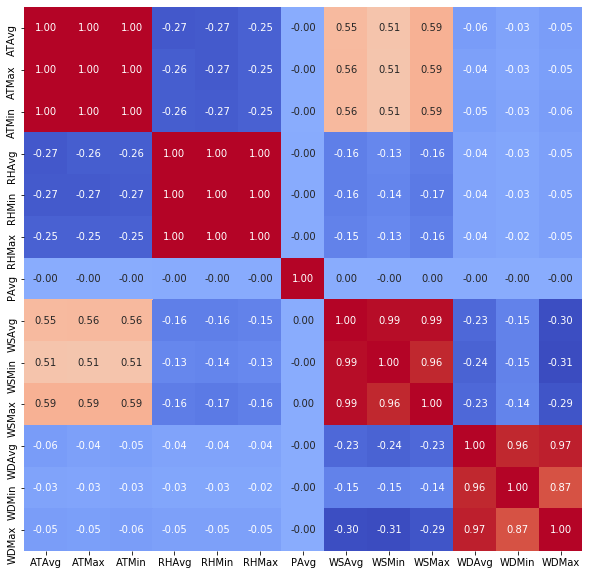

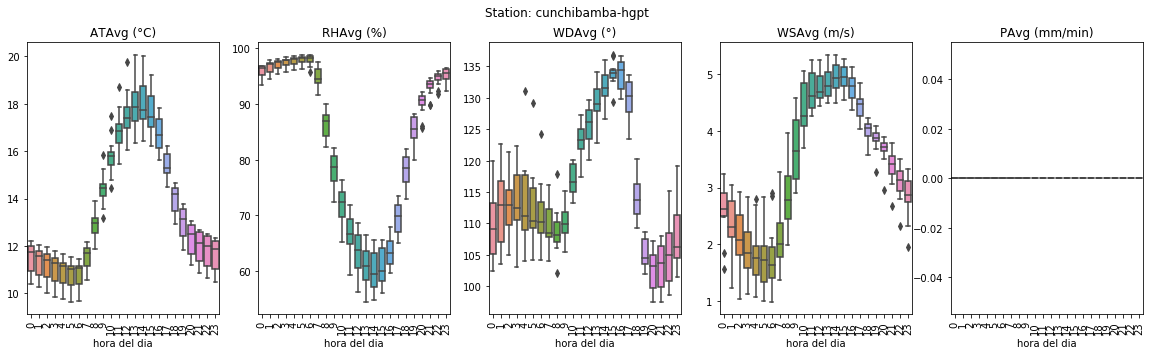

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


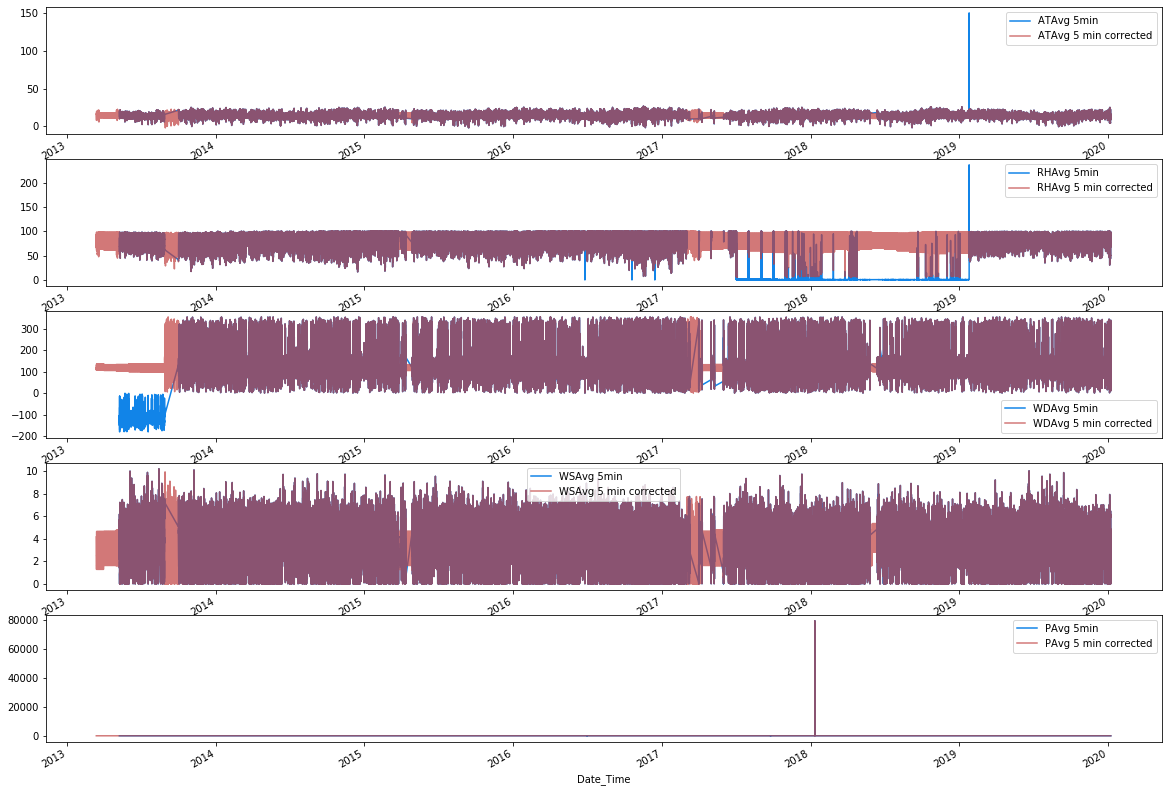

In [12]:
input_path = './data/PROCESSED'
path = './data/PROCESSED/STATIONS_CLEAN'
for i in range(len(aggregate_files)):
    if len(aggregate_files[i])>1:
        df1 = pd.read_csv(f'{input_path}/{files_ids[aggregate_files[i][0]]}')
        df2 = pd.read_csv(f'{input_path}/{files_ids[aggregate_files[i][1]]}')
        df = df1.append(df2)
    else:
        df = pd.read_csv(f'{input_path}/{files_ids[aggregate_files[i][0]]}')
  
    ## predare dataset (drop NAs, set date as index...)
    df = prepareDataset(df, dfname=aggregate_files[i][0], dropna = True)
  
    ## get basic stats
    results = basic_info(df)
    results.to_csv(f'{path}/{aggregate_files[i][0]}_basic_info.csv')

    ## correlations matrix of variables
    df_corr = df.corr()
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(df.corr(), annot=True, fmt='.2f', 
            cmap='coolwarm', cbar=False)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    fig.savefig(f'{path}/{aggregate_files[i][0]}_corrmatrix.png',dpi = 75)
    
    ### fill the gaps
    df1, df5_gaps, df5 = fill_the_gaps(df)

    ### Complete de series
    df = df5.asfreq(freq='5T')

    ### Split datetime into components
    split_into_times(df)

    ## run validation for every feature and row
    df = validate_values_df(df)

    ## Fix wrong values by filling with NAnn and then with the median value for the month and hour of day
    df = fix_errors(df, function='median', start_col =1, end_col=14)

    ### Plot mayor features
    degree_sign = u'\N{DEGREE SIGN}'
    units = {'ATAvg':f'({degree_sign}C)',
         'RHAvg': '(%)',
         'WDAvg': f'({degree_sign})',
         'WSAvg':'(m/s)',
         'PAvg':'(mm/min)'}
    
    variables = ['ATAvg','RHAvg','WDAvg', 'WSAvg','PAvg']
    
    fig, axes = plt.subplots(1,5,figsize=(20,5))
    fig.suptitle(f'Station: {aggregate_files[i][0]}')
    for variable,ax in zip(variables,axes.flatten()):
        data = df[[variable,'hour','month']].groupby(['hour','month']).median().reset_index()
        ax.set_title(f'{variable} {units[variable]}')
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
        ax.tick_params(axis='both', which='major', labelsize=10)
        sns.boxplot(y=variable, x= 'hour', data=data, orient='v', ax=ax).set(xlabel= 'hora del dia',ylabel=None)
    fig.savefig(f'{path}/{aggregate_files[i][0]}_var_boxplot.png',dpi = 75)

    # View corrected values
    fig, axes = plt.subplots(5,1,figsize= (20,15))
    for a, ax in enumerate(axes.flatten()):
        df5_gaps[variables[a]].plot(ax = ax,color = '#1184e8')
        df[variables[a]].plot(ax=ax, alpha = 0.7, color ='#bf3f3f')
        ax.legend([f'{variables[a]} 5min',f'{variables[a]} 5 min corrected'])
        fig.savefig(f'{path}/{aggregate_files[i][0]}_time_series.png',dpi = 75)
   
    ### Wind speed and direction transformation to vectors
    df = wind_to_vectors(df)  

    ### Add periodicity
    df = get_periodicity(df)

    ## Final columns
    df = df[['ATAvg','ATMax','ATMin',
         'RHAvg','RHMin','RHMax',
         'PAvg',
         'WDAvg','WSAvg','WAvgx','WAvgy', 'WMaxx', 'WMaxy', 'WMinx', 'WMiny',
         'Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']]

    ### Export to local 
    df.to_csv(f'{path}/{aggregate_files[i][0]}_validation.csv')

In [14]:
df = pd.read_csv(f'{input_path}/{files_ids[aggregate_files[i][0]]}')

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
df[1:5].drop(columns = df.columns[0])

,Date_Time,Type,Freq,file_name,ATAvg,ATMax,ATMin,BAT,PAvg,RHAvg,RHMax,RHMin,WDAvg,WDMax,WDMin,WSAvg,WSMax,WSMin
1,2013-02-08 15:00:00,NaN,1hora,05-HGPT-MT-03.- Estacion Cunchibamba/2013-03-0...,19.87,20.36,19.53,14.05,9.0,51.42,52.68,49.95,151.90,0.00,NaN,4.23,6.08,2.52
2,2013-02-08 16:00:00,NaN,1hora,05-HGPT-MT-03.- Estacion Cunchibamba/2013-03-0...,18.12,19.55,17.21,14.13,0.0,61.13,68.50,49.83,306.95,311.17,NaN,2.99,4.79,0.67
3,2013-02-08 17:00:00,NaN,1hora,05-HGPT-MT-03.- Estacion Cunchibamba/2013-03-0...,17.17,18.04,16.63,14.19,0.0,64.94,68.78,60.49,338.65,315.94,NaN,1.80,3.67,0.00
4,2013-02-08 18:00:00,NaN,1hora,05-HGPT-MT-03.- Estacion Cunchibamba/2013-03-0...,17.00,17.34,16.49,13.97,0.0,66.28,69.84,61.50,212.16,0.00,NaN,1.18,2.46,0.36
